<div style="text-align: right;">
Adrián Rubio
</div>

# NVIDIA Shares Prediction

### Introduction

In this project, predictions will be made using different time series methods, with the goal of predicting, in our case, the number of NVIDIA shares traded. The data we will use is found in:
https://www.kaggle.com/code/joshuabaliliongcoy/nvidia-stock-prediction-with-time-series-analysis/input

The dataset contains:
- Date: Date of incoming stock.
- Open: Opening price of the stock.
- High: Highest stock price of the day.
- Low: Lowest stock price of the day.
- Close: Closing price of the stock.
- Volume: Total number of shares traded.

The goal of this project is to study the behavior and predict the future volume of NVIDIA shares.

In [1]:
#Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from io import StringIO
import contextlib
import re

# pmdarima
# !pip install pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
#!pip install skforecast
#from skforecast.Sarimax import Sarimax
#from skforecast.ForecasterSarimax import ForecasterSarimax
#from skforecast.model_selection_sarimax import backtesting_sarimax
#from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", InterpolationWarning)

In [2]:
# Import our data set
nvd = pd.read_csv("C:/Users/adria/Desktop/Master Data Science & IA/Mineria de datos & Modelizacion predictiva/3. Series temporales/Tarea/Datos_tarea/NVDA.csv")

In [3]:
nvd.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,1999-01-22,0.037615,0.041016,0.048828,0.038802,0.043750,2714688000
1,1999-01-25,0.041556,0.045313,0.045833,0.041016,0.044271,510480000
2,1999-01-26,0.038331,0.041797,0.046745,0.041146,0.045833,343200000
3,1999-01-27,0.038212,0.041667,0.042969,0.039583,0.041927,244368000
4,1999-01-28,0.038092,0.041536,0.041927,0.041276,0.041667,227520000


Adjust the date format to our dataset index
and we're left with the variable we want to analyze: "Volume"

In [4]:
nvd = nvd[["Date", "Volume"]]
nvd['Date']=pd.to_datetime(nvd['Date'])  # format='%YM%m')
nvd.index = nvd["Date"]
del nvd["Date"]
# Preview the data
nvd

,Volume
Date,
1999-01-22,2714688000
1999-01-25,510480000
1999-01-26,343200000
1999-01-27,244368000
1999-01-28,227520000
...,...
2025-02-10,216989100
2025-02-11,178902400
2025-02-12,160278600



We observe that our data has an irregular distribution of dates, in our case we are interested in the data for the first day of the month

In [5]:
nvd[nvd.index.day == 1].head()

#nvd_orig = nvd[nvd.in10dex.day == 1]
#nvd[100:105]

,Volume
Date,
1999-02-01,154704000
1999-03-01,92160000
1999-04-01,30432000
1999-06-01,98544000
1999-07-01,88992000


We can see how there are months where there is no data for the first day, as seen in May 1999. To resolve this, we need to impute them with the resample function, indicating the frequency of our data, which will be the beginning of each month.

Then we check for the amount of null data that may be present in our data.

In [6]:
nvd = nvd.resample('MS').first()

print(nvd.isna().sum())

Volume    0
dtype: int64


We see that there is no null data, then we make a graph to visualize our data.

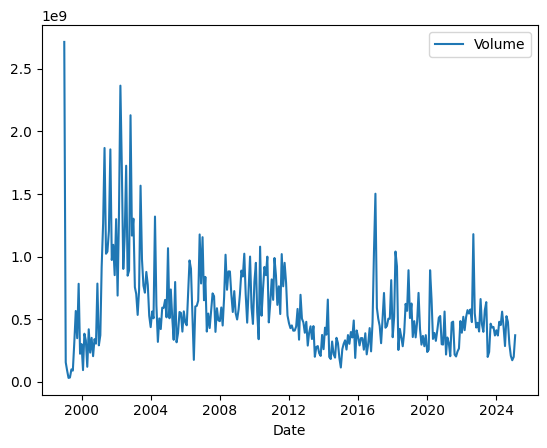

In [7]:
sns.lineplot(nvd)
plt.show()

It is observed that the series is not stationary, as the mean fluctuates, and it also does not exhibit homoscedastic variance.

The appropriate treatment would be to apply the logarithm to eliminate heteroscedasticity
and differentiate it in order d to seek stationarity in the mean.

Likewise, seasonal behavior appears to be observed throughout the series.

We will break down the time series:

- The multiplicative model is appropriate when seasonality varies proportionally to the trend
- The additive model is appropriate when seasonality adds to the overall trend

In our case, we will compare both models

In [8]:
# Perform multiplicative seasonal decomposition since the variance is not homoscedastic,
# but we will use both methods to observe them equally
nvd_de_mult = seasonal_decompose(nvd, model='multiplicative') 
nvd_de_addi = seasonal_decompose(nvd, model='additive') 

In [9]:
# multiplicative
print(f'The month with the lowest coefficient is: {nvd_de_mult.seasonal.idxmin(),nvd_de_mult.seasonal.min()}')
print(f'The month with the highest coefficient is: {nvd_de_mult.seasonal.idxmax(),nvd_de_mult.seasonal.max()}')

# additive
print(f'\nThe month with the lowest coefficient is: {nvd_de_addi.seasonal.idxmin(),nvd_de_addi.seasonal.min()}')
print(f'The month with the highest coefficient is: {nvd_de_addi.seasonal.idxmax(),nvd_de_addi.seasonal.max()}')

The month with the lowest coefficient is: (Timestamp('1999-02-01 00:00:00'), 0.8665044807728943)
The month with the highest coefficient is: (Timestamp('1999-04-01 00:00:00'), 1.1562523222495318)

The month with the lowest coefficient is: (Timestamp('1999-02-01 00:00:00'), -90787068.3840812)
The month with the highest coefficient is: (Timestamp('1999-04-01 00:00:00'), 89727046.61591882)


We observe:
- The multiplicative model:
    - The lowest seasonality occurs on 1/02/1999, where a relative decrease of 13.35% relative to the trend is observed.
    - The highest seasonality occurs on 1/04/1999, where a relative increase of 15.63% relative to the trend is observed.
- The additive model:
    - The lowest seasonality occurs on 1/02/1999, where a decrease of approximately -90787068.38 units relative to the trend is observed.
    - The highest seasonality occurs on 1/04/1999, where an increase of approximately 89727046.61 units relative to the trend is observed.

In [10]:
print(nvd_de_mult.seasonal)

print("\nIn February 2025, the number of NVIDIA shares decreased by 13.35% compared to the global average.")

Date
1999-01-01    1.011760
1999-02-01    0.866504
1999-03-01    1.069839
1999-04-01    1.156252
1999-05-01    0.958690
                ...   
2024-10-01    1.004022
2024-11-01    1.016489
2024-12-01    0.996716
2025-01-01    1.011760
2025-02-01    0.866504
Freq: MS, Name: seasonal, Length: 314, dtype: float64

In February 2025, the number of NVIDIA shares decreased by 13.35% compared to the global average.


In [11]:
print(nvd_de_addi.seasonal)

print("\nIn March 1999, the number of NVIDIA shares increased by 2,286,0880 units compared to the global average.")

Date
1999-01-01    1.640578e+07
1999-02-01   -9.078707e+07
1999-03-01    2.286088e+07
1999-04-01    8.972705e+07
1999-05-01    1.817662e+07
                  ...     
2024-10-01   -1.162895e+07
2024-11-01    1.687412e+07
2024-12-01   -1.479900e+07
2025-01-01    1.640578e+07
2025-02-01   -9.078707e+07
Freq: MS, Name: seasonal, Length: 314, dtype: float64

In March 1999, the number of NVIDIA shares increased by 2,286,0880 units compared to the global average.


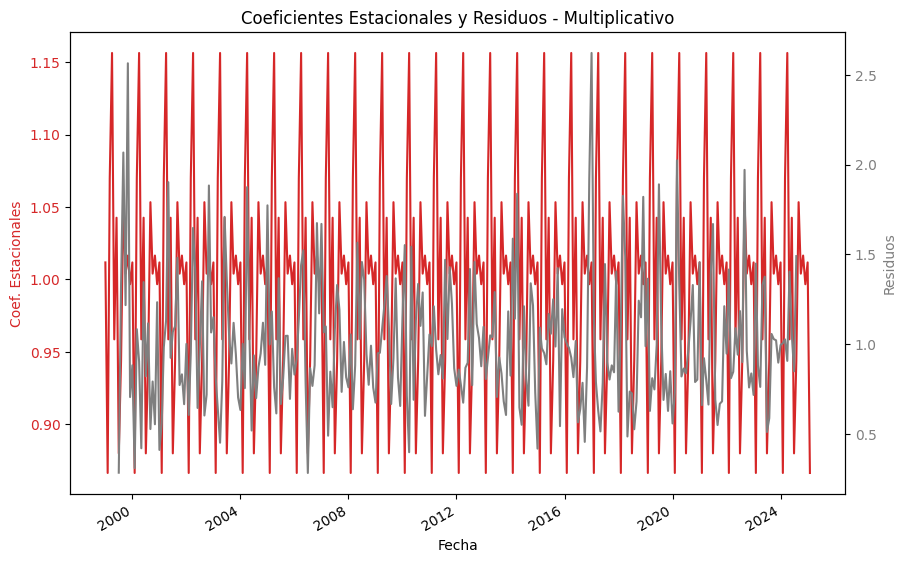

In [12]:
# Create a chart with two axes and share the x-axis ------- MULTIPLICATIVE
fig, ax1 = plt.subplots(figsize=(10,6))

# Primera serie en el eje izquierdo (ax1)
color = 'tab:red'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Coef. Estacionales', color=color)
ax1.plot(nvd_de_mult.seasonal, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=30, ha='right')
# Segunda serie en el eje derecho (ax2)
ax2 = ax1.twinx()  # Compartir el eje x
color = 'tab:grey'
ax2.set_ylabel('Residuos', color=color)
ax2.plot(nvd_de_mult.resid, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Ajustes de diseño
plt.title('Coeficientes Estacionales y Residuos - Multiplicativo')
plt.show()

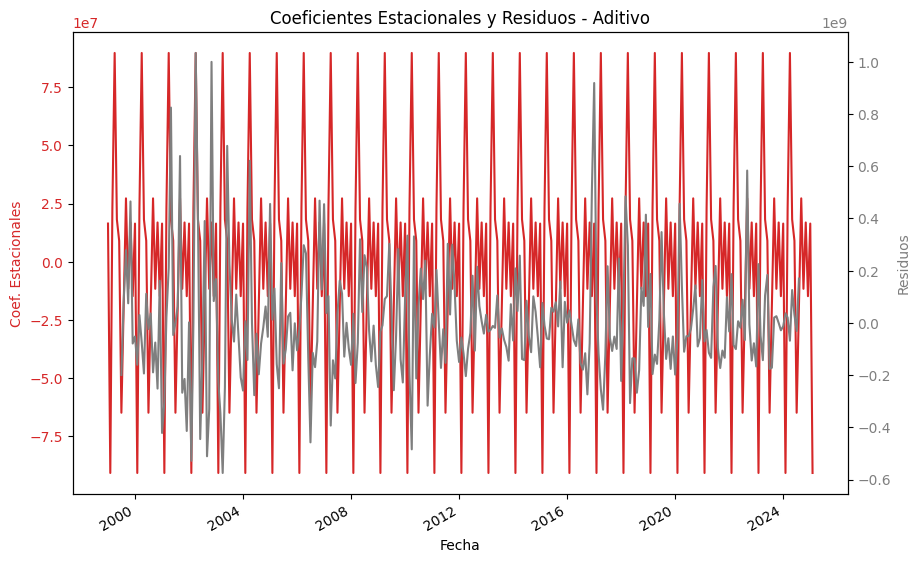

In [13]:
# Create a chart with two axes and share the x-axis ------- ADDITIVE
fig, ax1 = plt.subplots(figsize=(10,6))

# Primera serie en el eje izquierdo (ax1)
color = 'tab:red'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Coef. Estacionales', color=color)
ax1.plot(nvd_de_addi.seasonal, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=30, ha='right')
# Segunda serie en el eje derecho (ax2)
ax2 = ax1.twinx()  # Compartir el eje x
color = 'tab:grey'
ax2.set_ylabel('Residuos', color=color)
ax2.plot(nvd_de_addi.resid, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Ajustes de diseño
plt.title('Coeficientes Estacionales y Residuos - Aditivo')
plt.show()

We can observe seasonality in both the multiplicative and additive schemes. Regarding the residuals, we see that in the multiplicative scheme, there is greater variation in the years 1999 and 2017; in contrast, in the additive scheme, we can observe more pronounced variation in the residuals in the years 2001, 2002, 2003, and 2017.

For more detail, we will examine each component separately for both the multiplicative and additive schemes.

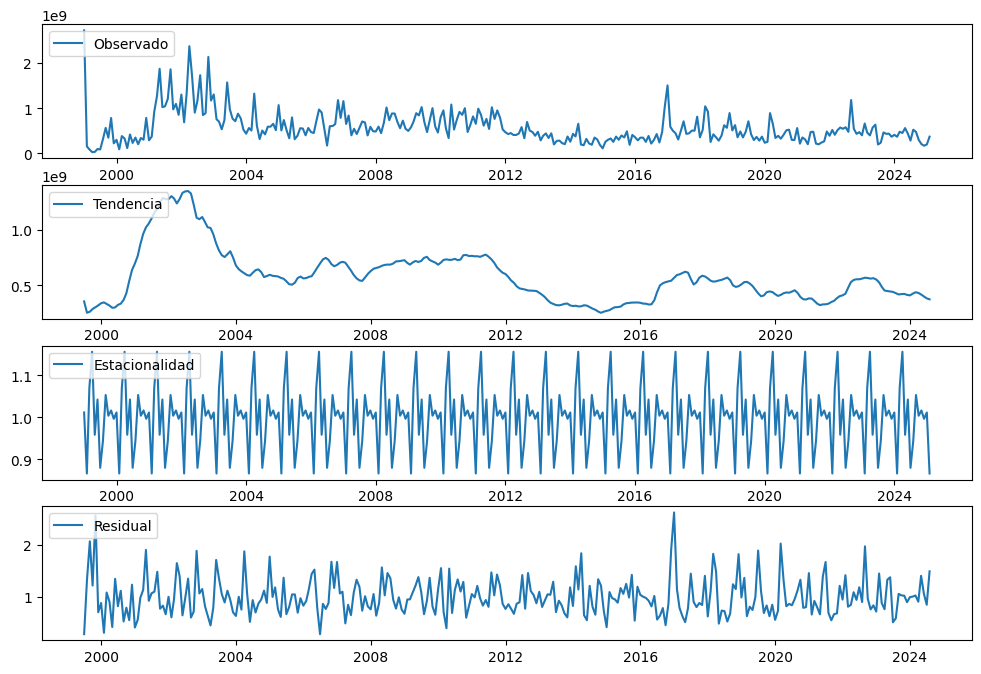

In [14]:
# MULTIPLICATIVO
#al representarlo de la forma anterior, no se obseran las fechas en todos los gráficos, por lo que:
# Visualizar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(nvd_de_mult.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(nvd_de_mult.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(nvd_de_mult.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(nvd_de_mult.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

In the multiplicative scheme, we can observe in the observed data that there are high values ​​in the years 2001, 2002, and 2003, due to the trend of the series. The trend of the series was upward in the years mentioned above, and over the following years, it has slowly decreased. We can see how it exhibits clear seasonality. And the residuals are random and show no pattern.

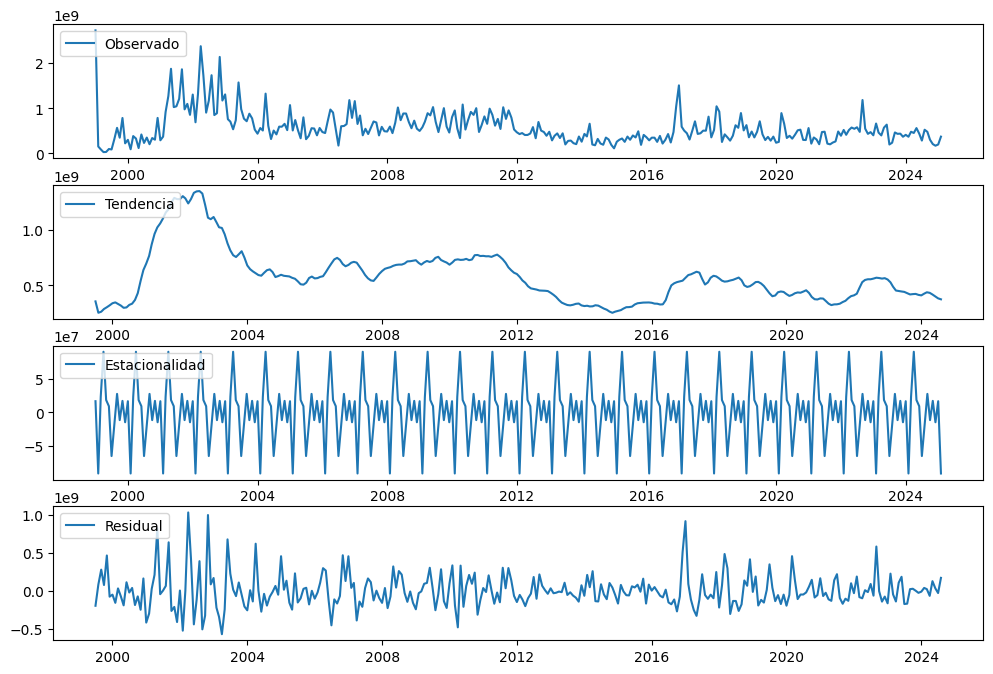

In [15]:
# ADITIVO
#al representarlo de la forma anterior, no se obseran las fechas en todos los gráficos, por lo que:
# Visualizar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(nvd_de_addi.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(nvd_de_addi.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(nvd_de_addi.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(nvd_de_addi.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

In the additive scheme, we can observe in the observed data that there are high values ​​in the years 2001, 2002, and 2003, due to the series trend and the residuals. The series trend was upward in the years mentioned above, and it has slowly decreased over the following years. We can see how it exhibits clear seasonality. And the residuals are random and show no pattern.

We could visualize which years could be those where the greatest number of NVIDIA shares have been registered.

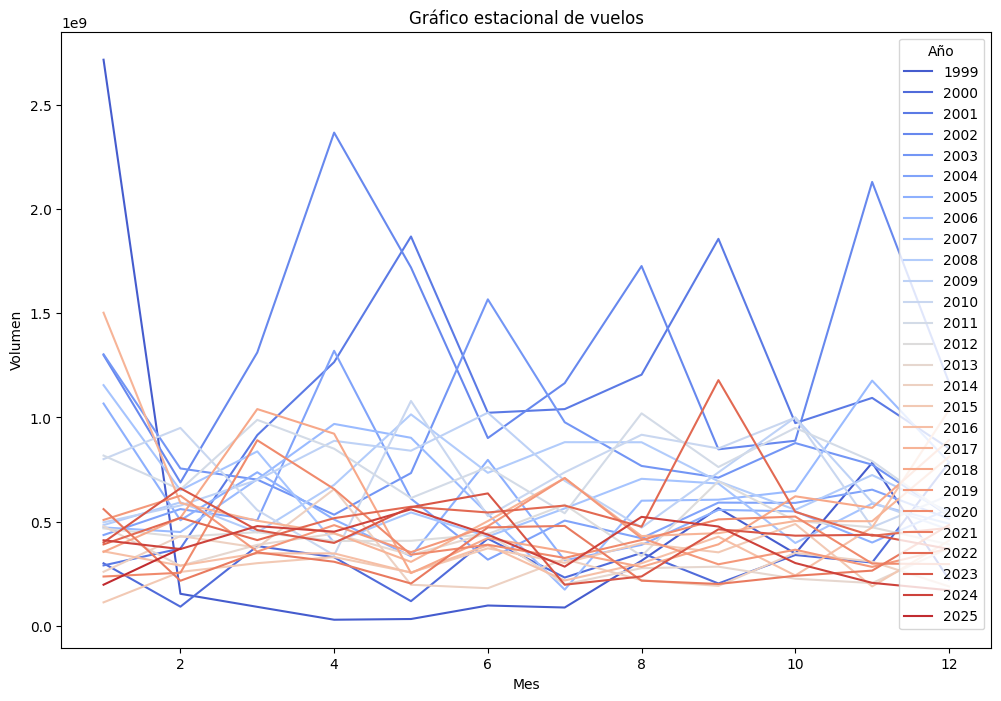

In [16]:
nvd['Año'] = pd.to_datetime(nvd.index, format='%YM%m').year
sns.set_palette("coolwarm", 27)
plt.figure(figsize=(12, 8))
for Año, datos_año in nvd.groupby('Año'):
    plt.plot(datos_año.index.month, datos_año['Volume'], label=str(Año))

# Añadir leyendas y título
plt.legend(title='Año')
plt.title('Gráfico estacional de vuelos')
plt.xlabel('Mes')
plt.ylabel('Volumen')

# Mostrar el gráfico
plt.show()

We can roughly see how the years 2001, 2002, and 2003 were the years with the highest number of actions, which makes sense given the conclusions we drew earlier.

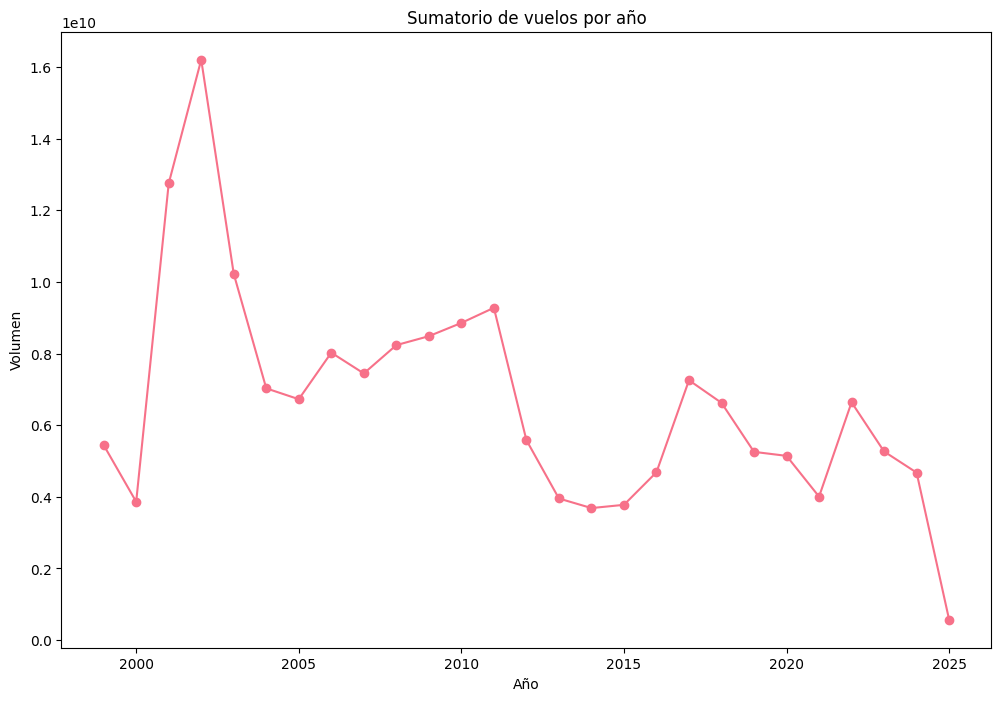

In [17]:
# Obtener el sumatorio por año
sumatorio_por_año = nvd.groupby('Año')['Volume'].sum()

plt.figure(figsize=(12, 8))

# Utilizar la paleta "husl" de Seaborn
sns.set_palette("husl")

# Graficar el sumatorio por año
plt.plot(sumatorio_por_año.index, sumatorio_por_año, marker='o')

# Añadir leyendas y título
plt.title('Sumatorio de vuelos por año')
plt.xlabel('Año')
plt.ylabel('Volumen')

# Mostrar el gráfico
plt.show()

We split our data into two sets: train and test, with the goal of making predictions and comparing them with the actual data we have.

In [18]:
nvd_train = nvd.loc[:'2024-02-01 00:00:00']
nvd_train

,Volume,Año
Date,,
1999-01-01,2714688000,1999
1999-02-01,154704000,1999
1999-03-01,92160000,1999
1999-04-01,30432000,1999
1999-05-01,33840000,1999
...,...,...
2023-10-01,433298000,2023
2023-11-01,437593000,2023
2023-12-01,369317000,2023


In [19]:
nvd_test = nvd['2024-03-01 00:00:00':]
len(nvd_test)

12

<Axes: xlabel='Date', ylabel='Volume'>

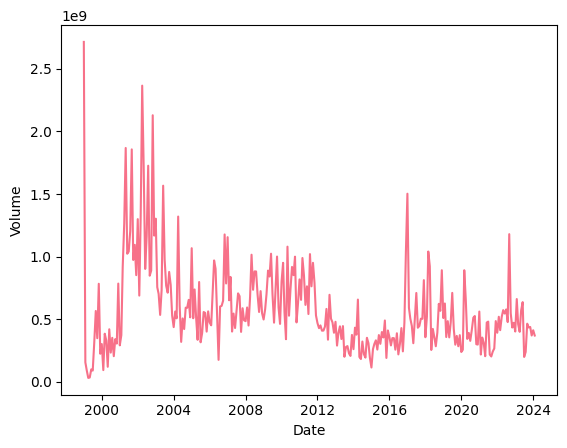

In [20]:
sns.lineplot(nvd_train['Volume'])

Noting that the variance is homoscedastic and exhibits a certain trend, we will transform the train data with a logarithm and differentiate the series later, aiming for the series to be stationary in both mean and variance.

<Axes: xlabel='Date', ylabel='Volume'>

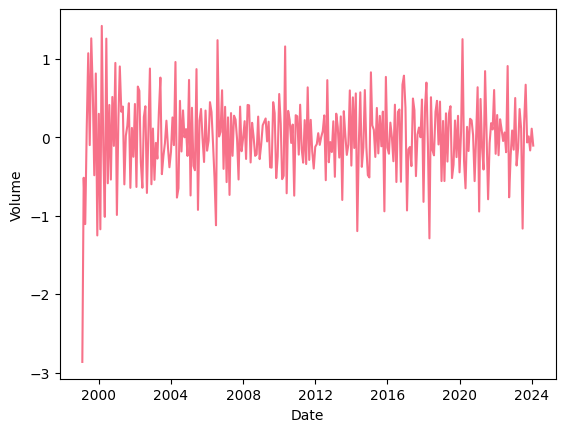

In [21]:
nvdTr_log = np.log(nvd_train['Volume'])
nvdTr_logdiff = nvdTr_log.diff().dropna()

sns.lineplot(nvdTr_logdiff)

We can see that the series is stationary in mean, but not in variance, although the heteroskedastic variance of the original series has improved significantly. We will use these transformed data with the following smoothing methods.

In [22]:
# Comprobamos que no hay valores nulos
nvdTr_logdiff.isna().sum()

0

Next, we'll make predictions using different smoothing methods, taking into account several characteristics:

#### If the model has no trend or seasonality: simple smoothing.
#### If the model has a trend and no seasonality: double smoothing.
#### If the model has a trend and seasonality: Holt-Winters smoothing.

# Simple Smoothing Model


In [23]:
# Aplicar suavizado Alisado simple.
nvd_train.index.freq = 'MS'
# Aplicar suavizado exponencial simple.
modelo_as = sm.tsa.SimpleExpSmoothing(nvdTr_logdiff, initialization_method="estimated").fit()
# Para seleccionar distintas alphas, fit(smoothing_level=alpha)
# Calcular la predicción para 1 año
predicciones_as = modelo_as.forecast(steps=12)
# Para ver parámetros, e.g.: alpha = 0.995
modelo_as.summary()

Dep. Variable:,Volume,No. Observations:,301
Model:,SimpleExpSmoothing,SSE,79.600
Optimized:,True,AIC,-396.358
Trend:,None,BIC,-388.944
Seasonal:,None,AICC,-396.223
Seasonal Periods:,None,Date:,"Fri, 25 Apr 2025"
Box-Cox:,False,Time:,19:43:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
initial_level,-0.0066287,l.0,True


We can see low SSE relative to the series we're working with. We see how 𝛼 has a value of 1.4901e-08, which tells us that it gives very little weight to current data and very high weight to past values.

We should try more advanced smoothing models and check the AIC, BIC, and AICC criteria of future models to determine which one might be the most appropriate.

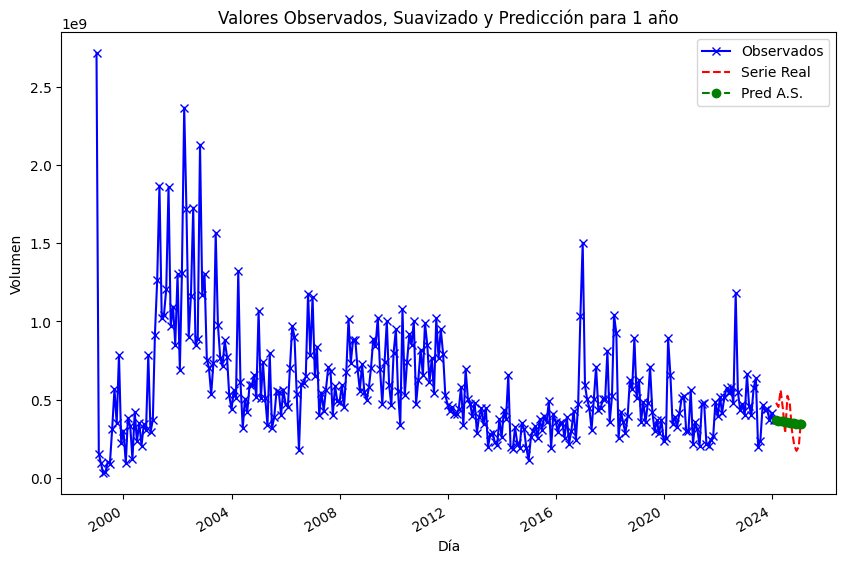

In [24]:
# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + predicciones_as.cumsum()
pred_final_as = np.exp(pred_log)

# Crear un gráfico con matplotlib
plt.figure(figsize=(10, 6))
# Valores observados
plt.plot(nvd_train.index, nvd_train["Volume"], label='Observados', marker='x', linestyle='-', color='blue')
# Valores reales
plt.plot(nvd_test.index, nvd_test['Volume'], label='Serie Real', linestyle='--', color='red')
# Predicción para 1 año
plt.plot(pred_final_as.index, pred_final_as, label='Pred A.S.', linestyle='--', marker='o', color='green')

plt.xlabel('Día')
plt.ylabel('Volumen')
plt.title('Valores Observados, Suavizado y Predicción para 1 año')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

We see how the prediction with the Simple Smoothing smoothing method is not the most optimal.

# Double Exponential Smoothing

For the Double Smoothing smoothing method, we'll create two predictive models: one with the additive trend and one with the multiplicative trend; we'll choose the one that gives us the best results.

In [25]:
# Aplicar suavizado exponencial doble (Holt). ADITIVO
modelo_holt_add = sm.tsa.ExponentialSmoothing(nvdTr_logdiff, trend='add', damped_trend=False).fit()
# Obtener predicciones para 1 año
predicciones_h_add = modelo_holt_add.forecast(steps=12)
# Mostrar la descripción del modelo
modelo_holt_add.summary()
# para controlar los valores de alpha y beta: .fit(smooothing_level = alpha, smoothing_slope = beta,
#optimized = False)

Dep. Variable:,Volume,No. Observations:,301
Model:,ExponentialSmoothing,SSE,79.580
Optimized:,True,AIC,-392.436
Trend:,Additive,BIC,-377.607
Seasonal:,None,AICC,-392.150
Seasonal Periods:,None,Date:,"Fri, 25 Apr 2025"
Box-Cox:,False,Time:,19:43:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,1.4731e-08,beta,True


We see that it also has a slightly lower SSE error. We see how 𝛼 has a value of 1.4901e-08, which tells us that the weight it gives to the present data is minimal, as is the case with the simple smoothed model. Beta has a value of 1.4731e-08, indicating that no trend has been detected in the data. The AIC, BIC, and AICC values ​​are higher than the simple smoothed model; this indicates that the simple smoothed model seems more appropriate.

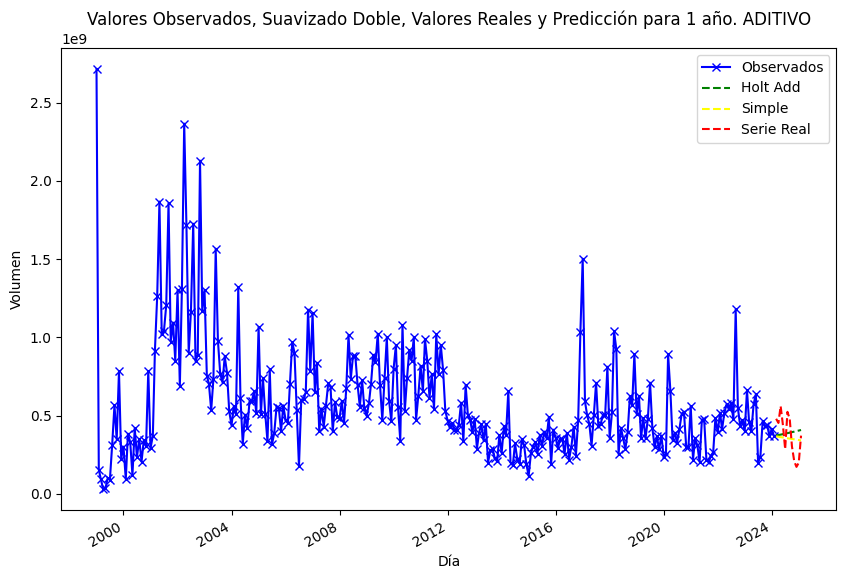

In [26]:
# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + predicciones_h_add.cumsum()
pred_final_ad_add = np.exp(pred_log)

# Representamos los distintos gráficos
plt.figure(figsize=(10, 6))
plt.plot(nvd_train.index, nvd_train['Volume'], label='Observados', marker='x', linestyle='-', color='blue')
plt.plot(pred_final_ad_add.index, pred_final_ad_add, label='Holt Add', linestyle='--',color='green')
plt.plot(pred_final_as.index, pred_final_as, label='Simple', linestyle='--', color='yellow')
plt.plot(nvd_test.index, nvd_test['Volume'], label='Serie Real', linestyle='--', color='red')

plt.xlabel('Día')
plt.ylabel('Volumen')
plt.title('Valores Observados, Suavizado Doble, Valores Reales y Predicción para 1 año. ADITIVO')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

The Double Smoothing model with additive tendency does not predict adequately.

In [27]:
# Aplicar suavizado exponencial doble (Holt). MULTIPLICATIVO
modelo_holt_mul = sm.tsa.ExponentialSmoothing(nvdTr_logdiff+3, trend='mul', damped_trend=False).fit()
# Obtener predicciones para 1 año
predicciones_h_mul = modelo_holt_mul.forecast(steps=12)
# Mostrar la descripción del modelo
modelo_holt_mul.summary()
# para controlar los valores de alpha y beta: .fit(smooothing_level = alpha, smoothing_slope = beta,
#optimized = False)

Dep. Variable:,Volume,No. Observations:,301
Model:,ExponentialSmoothing,SSE,79.580
Optimized:,True,AIC,-392.435
Trend:,Multiplicative,BIC,-377.607
Seasonal:,None,AICC,-392.150
Seasonal Periods:,None,Date:,"Fri, 25 Apr 2025"
Box-Cox:,False,Time:,19:43:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,1.4859e-08,beta,True


The double smoothing method with multiplicative tendency we see how we can draw conclusions very similar to the double smoothing method with additive tendency.

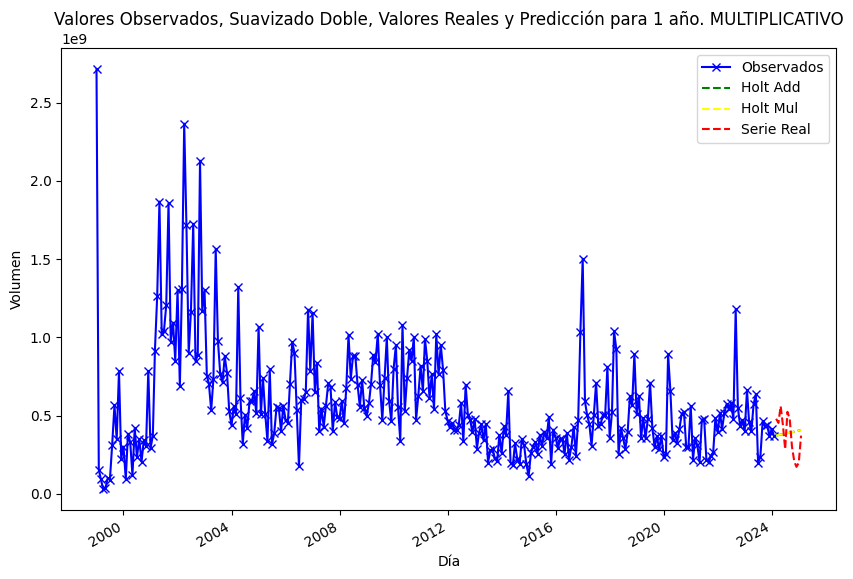

In [28]:
# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + (predicciones_h_mul-3).cumsum()
pred_final_ad_mul = np.exp(pred_log)

# Representamos los distintos gráficos
plt.figure(figsize=(10, 6))
plt.plot(nvd_train.index, nvd_train['Volume'], label='Observados', marker='x', linestyle='-', color='blue')
plt.plot(pred_final_ad_add.index, pred_final_ad_add, label='Holt Add', linestyle='--',color='green')
plt.plot(pred_final_ad_mul.index, pred_final_ad_mul, label='Holt Mul', linestyle='--', color='yellow')
plt.plot(nvd_test.index, nvd_test['Volume'], label='Serie Real', linestyle='--', color='red')

plt.xlabel('Día')
plt.ylabel('Volumen')
plt.title('Valores Observados, Suavizado Doble, Valores Reales y Predicción para 1 año. MULTIPLICATIVO')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

The Double Smoothing model with multiplicative bias does not predict adequately.

# Holt-Winters model

Finally, we perform the final smoothing method using the Holt-Winters model. We will create four predictive models based on the choice of trend and seasonality parameters. We will then check which model has the lowest MAE error.

In [29]:
# Trend= Aditivo, Seasonal= Aditivo  -----  MODELO 1

modelo_holt_winters_aa = sm.tsa.ExponentialSmoothing(nvdTr_logdiff, trend='add', 
                                                  seasonal='additive', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_aa = modelo_holt_winters_aa.forecast(steps=12)

# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + predicciones_hw_aa.cumsum()
pred_final_hw_aa = np.exp(pred_log)

# Calculamos el error MAE
errores_aa = abs(nvd_test['Volume']-pred_final_hw_aa)
mae_aa = np.mean(errores_aa)
print("Error MAE Modelo 1:",mae_aa)


# Trend= Multiplicativo, Seasonal= Aditivo  ----  MODELO 2

modelo_holt_winters_ma = sm.tsa.ExponentialSmoothing(nvdTr_logdiff+3, trend='mul', 
                                                  seasonal='additive', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_ma = modelo_holt_winters_ma.forecast(steps=12)

# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + (predicciones_hw_ma-3).cumsum()
pred_final_hw_ma = np.exp(pred_log)

# Calculamos el error MAE
errores_ma = abs(nvd_test['Volume']-pred_final_hw_ma)
mae_ma = np.mean(errores_ma)
print("Error MAE Modelo 2:",mae_ma)


# Trend= Aditivo, Seasonal= Multiplicativo  ----  MODELO 3

modelo_holt_winters_am = sm.tsa.ExponentialSmoothing(nvdTr_logdiff+3, trend='add', 
                                                  seasonal='multiplicative', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_am = modelo_holt_winters_am.forecast(steps=12)

# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + (predicciones_h_mul-3).cumsum()
pred_final_hw_am = np.exp(pred_log)

# Calculamos el error MAE
errores_am = abs(nvd_test['Volume']-pred_final_hw_am)
mae_am = np.mean(errores_am)
print("Error MAE Modelo 3:",mae_am)


# Trend= Multiplicativo, Seasonal= Multiplicativo  ----  MODELO 4

modelo_holt_winters_mm = sm.tsa.ExponentialSmoothing(nvdTr_logdiff+3, trend='mul', 
                                                  seasonal='multiplicative', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_mm = modelo_holt_winters_mm.forecast(steps=12)

# Desdiferenciamos la serie para representar las predicciones
last_log_value = nvdTr_log.iloc[-1]
pred_log = last_log_value + (predicciones_hw_mm-3).cumsum()
pred_final_hw_mm = np.exp(pred_log)

# Calculamos el error MAE
errores_mm = abs(nvd_test['Volume']-pred_final_hw_mm)
mae_mm = np.mean(errores_mm)
print("Error MAE Modelo 4:",mae_mm)

Error MAE Modelo 1: 137173323.75278684


C:\Users\adria\anaconda3\envs\ml_python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Error MAE Modelo 2: 137242205.02236286
Error MAE Modelo 3: 124755414.88707455
Error MAE Modelo 4: 128844916.41963923


C:\Users\adria\anaconda3\envs\ml_python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


We see how model 3 with additive trend and multiplicative seasonality has a lower MAE error, which is the best Holt-Winter model.

In [30]:
# Mostrar la descripción del modelo ganardor (Modelo 1)
modelo_holt_winters_am.summary()

Dep. Variable:,Volume,No. Observations:,301
Model:,ExponentialSmoothing,SSE,74.648
Optimized:,True,AIC,-387.693
Trend:,Additive,BIC,-328.379
Seasonal:,Multiplicative,AICC,-385.267
Seasonal Periods:,12,Date:,"Fri, 25 Apr 2025"
Box-Cox:,False,Time:,19:43:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,8.4892e-09,beta,True


We see that it has the lowest SSE error of the applied methods. We see how the alpha, beta, and gamma values ​​are very low, indicating that the weight given to the past is too high, and that the model was unable to detect trends or seasonality. We see that the AIC, BIC, and AICC metrics are greater than the simple smoothing metrics, which indicates that the simple smoothing model is the best, despite having the lowest SSE error.

We visualize the predictions of the winning Holt-Winters model and the parameters

In [31]:
predicciones_hw_am

2024-03-01    3.204456
2024-04-01    3.009584
2024-05-01    2.815216
2024-06-01    3.174390
2024-07-01    2.857535
2024-08-01    3.095558
2024-09-01    3.124397
2024-10-01    2.995961
2024-11-01    2.993443
2024-12-01    3.032998
2025-01-01    2.982435
2025-02-01    2.788994
Freq: MS, dtype: float64

In [32]:
modelo_holt_winters_am.params

{'smoothing_level': 1.490116119517688e-08,
 'smoothing_trend': 8.489166162330553e-09,
 'smoothing_seasonal': 1.2176260770647898e-18,
 'damping_trend': nan,
 'initial_level': 3.0231006400216587,
 'initial_trend': 7.873685216404874e-05,
 'initial_seasons': array([0.91510059, 1.0517175 , 0.98773398, 0.92391947, 1.04176888,
        0.9377595 , 1.01584541, 1.02528278, 0.9831105 , 0.98225887,
        0.99521279, 0.97859615]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

We ran a Holt Winters model on the series without any previous transformations to compare predictions.

C:\Users\adria\anaconda3\envs\ml_python\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


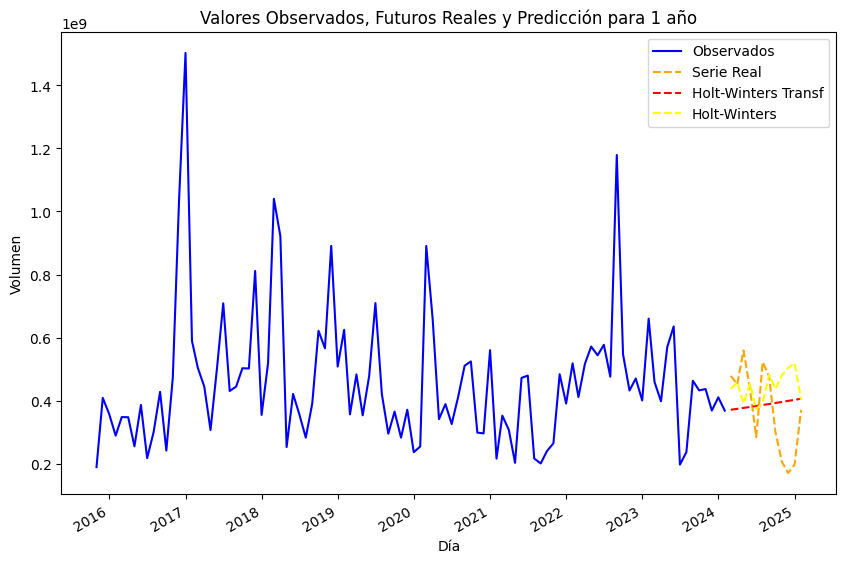

In [33]:
modelo_holt_winters_am = sm.tsa.ExponentialSmoothing(nvd_train["Volume"], trend='add', 
                                                  seasonal='multiplicative', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw_am = modelo_holt_winters_am.forecast(steps=12)


# Gráficas
plt.figure(figsize=(10, 6))
plt.plot(nvd_train.tail(100).index, nvd_train['Volume'].tail(100), label='Observados', linestyle='-', color='blue')
plt.plot(nvd_test.index, nvd_test['Volume'], label='Serie Real', linestyle='--', color='orange')
plt.plot(pred_final_hw_am.index, pred_final_hw_am, label='Holt-Winters Transf', linestyle='--',color='red')
plt.plot(predicciones_hw_am.index, predicciones_hw_am, label='Holt-Winters', linestyle='--',color='yellow')

plt.xlabel('Día')
plt.ylabel('Volumen')
plt.title('Valores Observados, Futuros Reales y Predicción para 1 año')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

We can see how both Holt Winters models fail to adequately predict future values. Next, we analyze the MAE errors of the Holt Winters MODEL 3.

In [34]:
print(errores_am.head())

Date
2024-03-01    1.071700e+08
2024-04-01    7.759992e+07
2024-05-01    1.820878e+08
2024-06-01    5.762375e+07
2024-07-01    9.893591e+07
Freq: MS, dtype: float64


(array([19783., 19844., 19905., 19967., 20028., 20089.]),
 [Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01')])

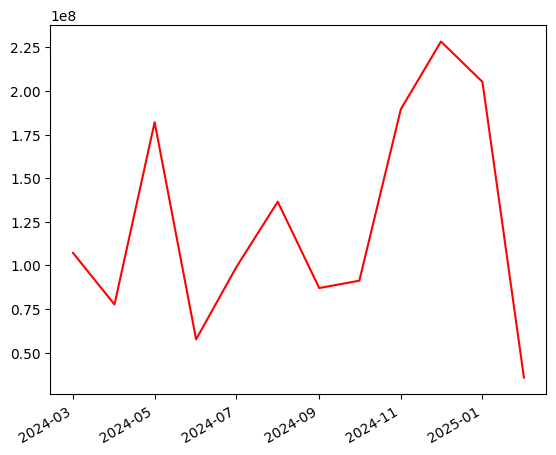

In [35]:
# esto nos permite conocer en qué meses se cometieron más errores
plt.plot(errores_am, label='errores', linestyle='-', color='red')
plt.xticks(rotation=30, ha='right')

We see how the model has greater difficulty predicting the latest data, although it has managed to get the final value of the future data right.

## Conclusion

The best smoothing method is the simple smoothing method, which yields the lowest AIC, BIC, and AICC metrics.

# ARIMA MODELS

We will now begin building predictive models using ARIMA models. The model is composed of three components: 
- AR (AutoRegressive), which models the relationship between the current value and past values.
- I (Integrated), which represents the number of differentiations required to make the series stationary by eliminating trends
- MA (Moving Average), which captures the dependence between the current value and past errors.

Text(0.5, 1.0, 'Serie original')

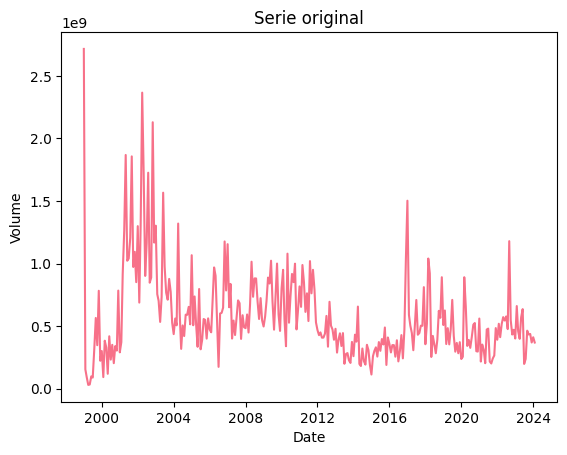

In [36]:
sns.lineplot(nvd_train["Volume"])
plt.title("Serie original")

We see how the data behave if we apply the logarithm to the series with the idea of ​​smoothing the heteroscedasticity presented by the variance.

Text(0.5, 1.0, 'Serie Transf.Logaritmo')

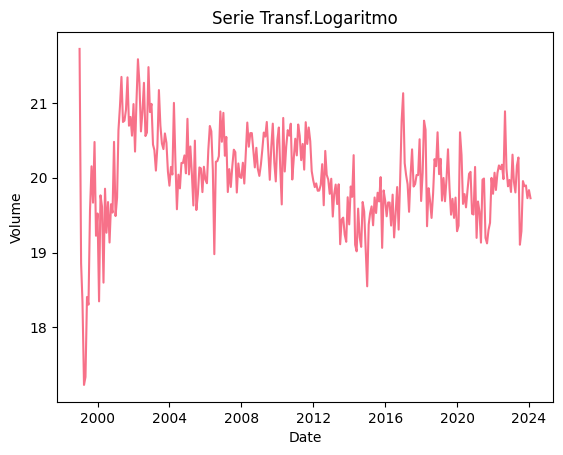

In [37]:
sns.lineplot(nvdTr_log)
plt.title("Serie Transf.Logaritmo")

We see how the variance has improved, but we see that the series shows trends. To solve this, we will apply differentiation with the idea of ​​ensuring that the series is stationary in mean.

Text(0.5, 1.0, 'Serie diferenciada de orden 1')

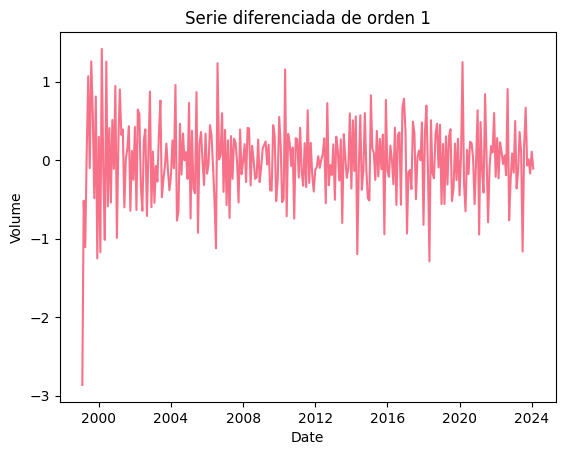

In [38]:
sns.lineplot(nvdTr_logdiff)
plt.title("Serie diferenciada de orden 1")

We apply the Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests to check whether the series is mean-stationary. We seek to have H0 rejected by the ADF test, and H0 not rejected by the KPSS test.

In [39]:
print('Test estacionariedad serie original')
print(f'ADF Statistic: {adfuller(nvd_train["Volume"])[0]}, p-value: {adfuller(nvd_train["Volume"])[1]}')
print(f'KPSS Statistic: {kpss(nvd_train["Volume"])[0]}, p-value: {kpss(nvd_train["Volume"])[1]}')

print('\nTest estacionariedad serie transformacion logarítmica')
print(f'ADF Statistic: {adfuller(nvdTr_log)[0]}, p-value: {adfuller(nvdTr_log)[1]}')
print(f'KPSS Statistic: {kpss(nvdTr_log)[0]}, p-value: {kpss(nvdTr_log)[1]}')

print('\nTest estacionariedad serie Transformada + diferenciada de orden 1')
print(f'ADF Statistic: {adfuller(nvdTr_logdiff)[0]}, p-value: {adfuller(nvdTr_logdiff)[1]}')
print(f'KPSS Statistic: {kpss(nvdTr_logdiff)[0]}, p-value: {kpss(nvdTr_logdiff)[1]}')

# Sería bueno diferenciar, ya que aunque solo haya pasado el test ADF satisfactoriamente indicandonos 
# que es estacionario en media; si diferenciamos las dos métricas nos indicarán esa estacionariedad en media.
# Además se pueden ver unas ligeras tendencias que fluctuan cuando no diferenciamos 
# y solo aplicamos la transformación logarítmiica

Test estacionariedad serie original
ADF Statistic: -2.795545631857888, p-value: 0.05891286530850683
KPSS Statistic: 0.8816924983056771, p-value: 0.01

Test estacionariedad serie transformacion logarítmica
ADF Statistic: -4.137974934180461, p-value: 0.0008376282534065433
KPSS Statistic: 0.4637371640312652, p-value: 0.04983397206503037

Test estacionariedad serie Transformada + diferenciada de orden 1
ADF Statistic: -10.878052293239474, p-value: 1.316205556013874e-19
KPSS Statistic: 0.05497286743930464, p-value: 0.1


We see how the original series fails both tests, the series with the logarithm satisfies only the ADF test, and the series with the logarithm and the differenced series does satisfy both tests, making the series mean-stationary. This can be visually seen in the following graphs. By differentiating the series once, I = 1 in our ARIMA model.

<Axes: title={'center': 'Transf.Log + Diferenciación orden 1'}, xlabel='Date'>

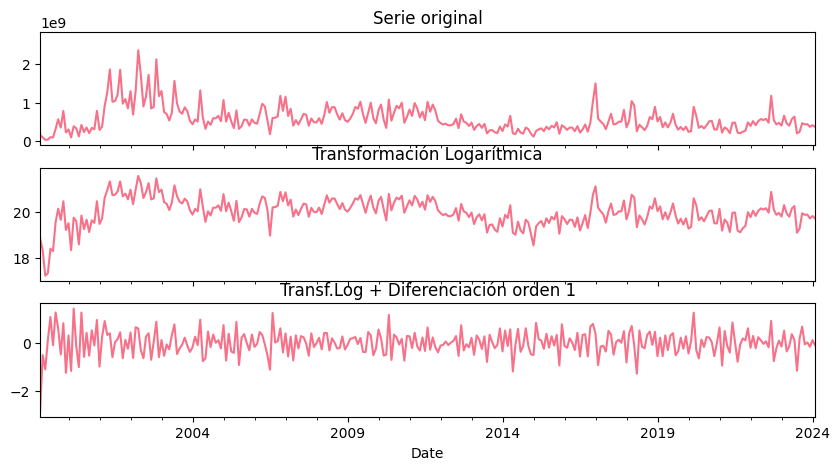

In [40]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5), sharex=True)
nvd_train["Volume"].plot(ax=axs[0], title='Serie original')
nvdTr_log.plot(ax=axs[1], title='Transformación Logarítmica')
nvdTr_logdiff.plot(ax=axs[2], title='Transf.Log + Diferenciación orden 1')

Next, to choose the values ​​of AR and MA, we will look at the lags that exceed the significance level (0.05) of the partial autocorrelation and autocorrelation functions, respectively.

Text(0.5, 1.0, 'Autoorrelación parcial serie diferenciada (order=1)')

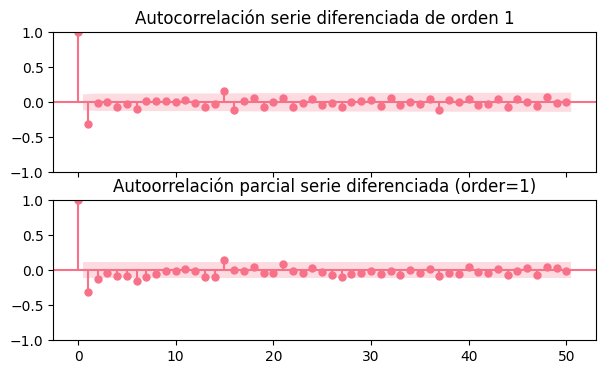

In [41]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(nvdTr_logdiff, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie diferenciada de orden 1')
plot_pacf(nvdTr_logdiff, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)')

We observe that the possible candidate ARIMA models are:
- Model 1: ARIMA (2, 1, 1)
- Model 2: ARIMA (6, 1, 1)

We decompose the series and analyze each component, both for an additive model and a multiplicative model.

In [42]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose_add = seasonal_decompose(nvdTr_logdiff, model='additive', extrapolate_trend='freq')
res_decompose_mul = seasonal_decompose(nvdTr_logdiff+3, model='multiplicative', extrapolate_trend='freq')

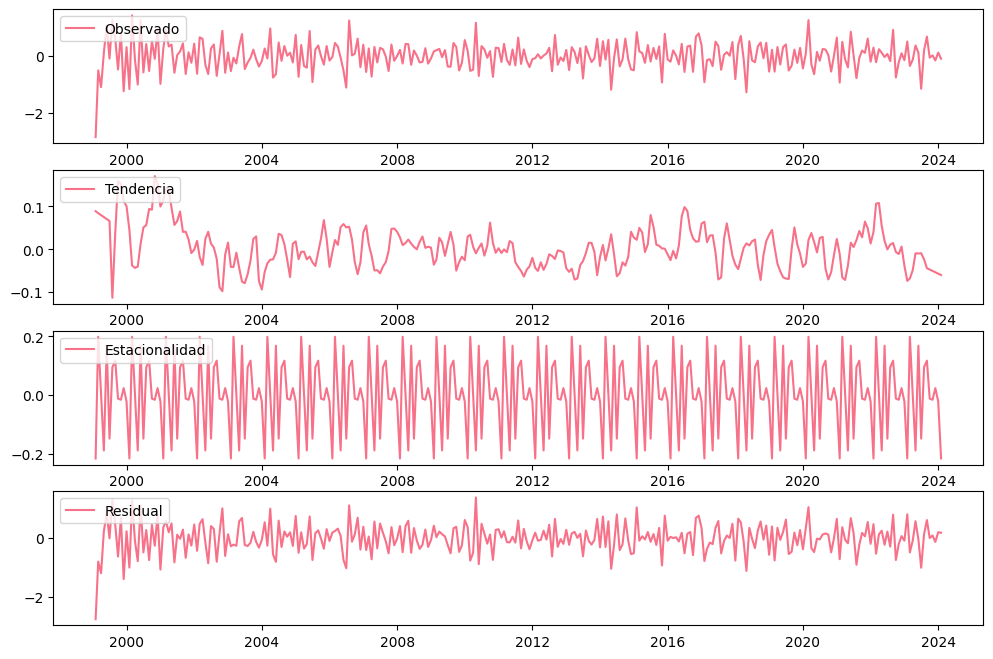

In [43]:
# Visualizar las componentes  -----  ADITIVO
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(res_decompose_add.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(res_decompose_add.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(res_decompose_add.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(res_decompose_add.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

We see how in the Additive model the residuals have a uniform distribution, the seasonality presents a clear pattern, and there is no clear trend in the series.

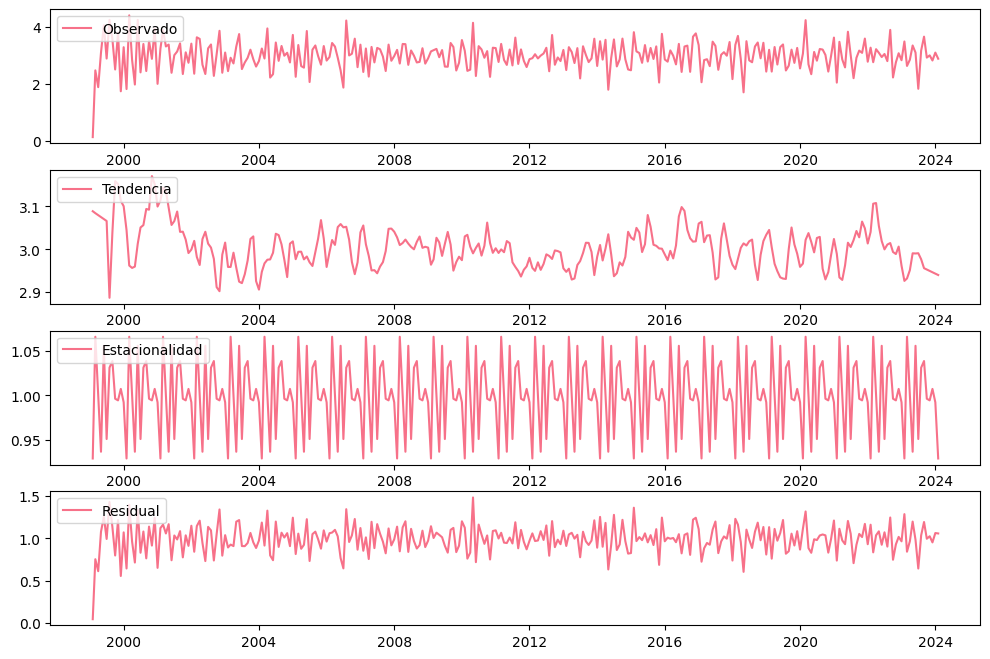

In [44]:
# Visualizar las componentes  -----  MULTILICATIVO
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(res_decompose_mul.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(res_decompose_mul.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(res_decompose_mul.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(res_decompose_mul.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

It can be seen how the same statements can be made for the multiplicative model as for the additive model. Later, we will analyze seasonality. In our case, we will perform a 12th-order differentiation because our data are distributed such that there is one observation per month, and our objective is to predict at a rate of one year, since a defined pattern is observed that repeats itself every year in the data.

In [45]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
nvd_train_diff1_12 = nvdTr_logdiff.diff(12).dropna()
print('\nTest estacionariedad serie diferenciada de orden 12')
print(f'ADF Statistic: {adfuller(nvd_train_diff1_12)[0]}, p-value: {adfuller(nvd_train_diff1_12)[1]}')
print(f'KPSS Statistic: {kpss(nvd_train_diff1_12)[0]}, p-value: {kpss(nvd_train_diff1_12)[1]}')


Test estacionariedad serie diferenciada de orden 12
ADF Statistic: -7.5150379562859735, p-value: 3.9236084316365274e-11
KPSS Statistic: 0.1901240859706888, p-value: 0.1


By performing the 12th-order differentiation, we see that it successfully passes the ADF and KPSS tests, indicating that the series is mean-stationary. We then follow the same steps above to determine AR and MA in terms of seasonality.

Text(0.5, 1.0, 'Autoorrelación parcial serie diferenciada (order=1)')

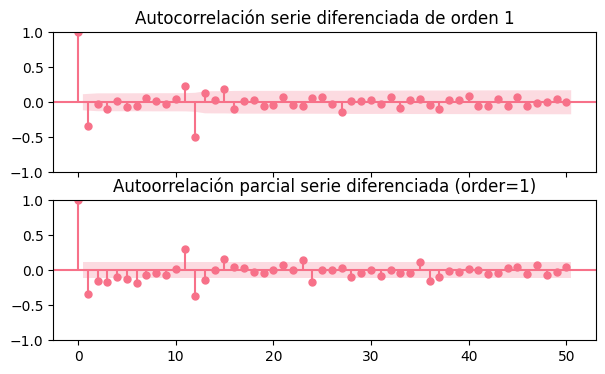

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(nvd_train_diff1_12, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie diferenciada de orden 1')
plot_pacf(nvd_train_diff1_12, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)')

We choose as possible ARIMA models:
- Model 1: ARIMA (2, 1, 1)(6, 1, 1)[12]
- Model 2: ARIMA (6, 1, 1)(6, 1, 1)[12]

We test these models against future data to see if they predict well.

In [47]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo1 = SARIMAX(endog = nvd_train["Volume"], order = (2, 1, 1), seasonal_order = (6, 1, 1, 12))
modelo2 = SARIMAX(endog = nvd_train["Volume"], order = (6, 1, 1), seasonal_order = (6, 1, 1, 12))

modelo_res1 = modelo1.fit(disp=0)
modelo_res2 = modelo2.fit(disp=0)
warnings.filterwarnings("default")

In [48]:
print(modelo_res1.summary())
print(modelo_res2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Volume   No. Observations:                  302
Model:             SARIMAX(2, 1, 1)x(6, 1, 1, 12)   Log Likelihood               -6061.903
Date:                            Fri, 25 Apr 2025   AIC                          12145.807
Time:                                    19:46:31   BIC                          12186.137
Sample:                                01-01-1999   HQIC                         12161.967
                                     - 02-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1857      0.142      1.311      0.190      -0.092       0.463
ar.L2         -0.0813      0.115   

Looking at the two models and the AIC and BIC criteria, we see that the second model has slightly lower metrics, which is ideal. We see that in both models, the Ljung-Box test indicates that the residuals show no autocorrelation, which is ideal; however, the Jarque-Bera test indicates that the residuals are not normalized in both models. Furthermore, the choice of parameters in both models does not appear to have been the most appropriate.

In [49]:
from statsmodels.stats.diagnostic import acorr_ljungbox
estadistico_lb_1, p_valor_lb_1 = acorr_ljungbox(modelo_res1.resid, lags=[12]).iloc[0]
estadistico_lb_2, p_valor_lb_2 = acorr_ljungbox(modelo_res2.resid, lags=[12]).iloc[0]

print(f"El Test Ljung-Box para el modelo 1: Estadístico:{estadistico_lb_1}  p-valor:{p_valor_lb_1}\t")
print(f"El Test Ljung-Box para el modelo 2: Estadístico:{estadistico_lb_2}  p-valor:{p_valor_lb_2}")

# Ninguno de los dos modelos rechaza H0 por lo que existe autocorrelación significativa en los residuos

El Test Ljung-Box para el modelo 1: Estadístico:19.354300450674483  p-valor:0.08032937586937346	
El Test Ljung-Box para el modelo 2: Estadístico:17.88043016221895  p-valor:0.11936959964566529


In [50]:
# Predicción
# ==============================================================================
predicciones_statsmodels1 = modelo_res1.get_forecast(steps=12).predicted_mean
predicciones_statsmodels1.name = 'predicciones_statsmodels'
display(predicciones_statsmodels1.head(4))

predicciones_statsmodels2 = modelo_res2.get_forecast(steps=12).predicted_mean
predicciones_statsmodels2.name = 'predicciones_statsmodels'
display(predicciones_statsmodels2.head(4))

2024-03-01    5.090417e+08
2024-04-01    4.760315e+08
2024-05-01    3.070347e+08
2024-06-01    4.075595e+08
Freq: MS, Name: predicciones_statsmodels, dtype: float64

2024-03-01    4.966420e+08
2024-04-01    4.460869e+08
2024-05-01    3.112915e+08
2024-06-01    4.101000e+08
Freq: MS, Name: predicciones_statsmodels, dtype: float64

In [51]:
predicciones_statsmodels1

2024-03-01    5.090417e+08
2024-04-01    4.760315e+08
2024-05-01    3.070347e+08
2024-06-01    4.075595e+08
2024-07-01    3.627860e+08
2024-08-01    2.950371e+08
2024-09-01    4.075831e+08
2024-10-01    3.976919e+08
2024-11-01    3.300823e+08
2024-12-01    4.539322e+08
2025-01-01    4.124388e+08
2025-02-01    3.636843e+08
Freq: MS, Name: predicciones_statsmodels, dtype: float64

We represent both models in different graphs.

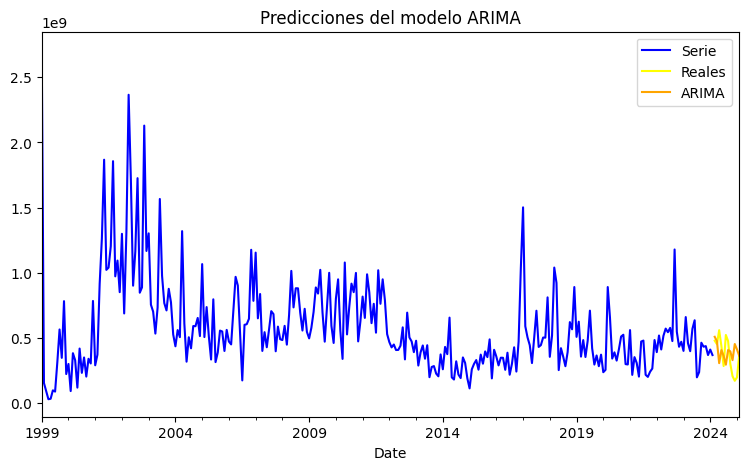

In [52]:
# Plot predictions - MODELO 1
fig, ax = plt.subplots(figsize=(9, 5))
nvd_train["Volume"].plot(ax=ax, label='Serie', color="blue")
nvd_test["Volume"].plot(ax=ax, label='Reales', color="yellow")
predicciones_statsmodels1.plot(ax=ax, label='ARIMA', color="orange")
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

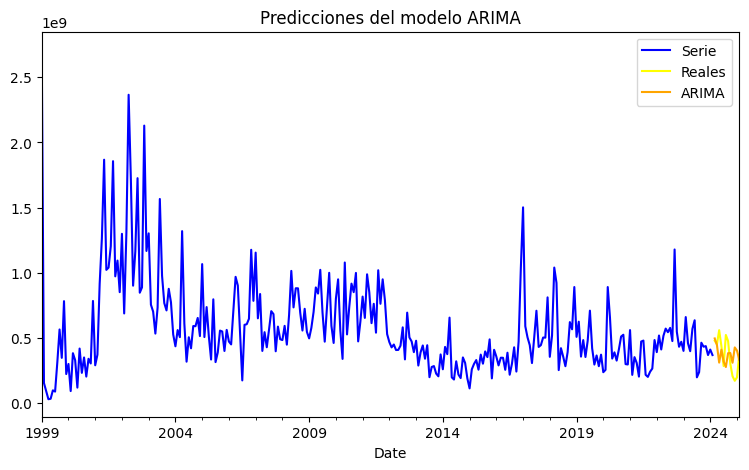

In [53]:
# Plot predictions - MODELO 2
fig, ax = plt.subplots(figsize=(9, 5))
nvd_train["Volume"].plot(ax=ax, label='Serie', color="blue")
nvd_test["Volume"].plot(ax=ax, label='Reales', color="yellow")
predicciones_statsmodels2.plot(ax=ax, label='ARIMA', color="orange")
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

We see how in both ARIMA models the predictions are unreliable.

In [54]:
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels1)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels1)
print(f'Mean Absolute Error (MAE): {mae}')
print()

# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels2)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels2)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 2.3272250473274004e+16
Root Mean Squared Error (RMSE): 152552451.54789877
Mean Absolute Error (MAE): 119633340.46901308

Mean Squared Error (MSE): 2.1675678871276572e+16
Root Mean Squared Error (RMSE): 147226624.193033
Mean Absolute Error (MAE): 113452863.94510631


Observing the errors of both models, we can see how model 2 presents lower errors, and is therefore the most suitable of the two.

In [55]:
nvd_test["Volume"] - predicciones_statsmodels1

Date
2024-03-01   -2.990671e+07
2024-04-01   -2.359051e+07
2024-05-01    2.528283e+08
2024-06-01    3.083252e+07
2024-07-01   -7.790055e+07
2024-08-01    2.284252e+08
2024-09-01    6.957195e+07
2024-10-01   -9.559743e+07
2024-11-01   -1.229545e+08
2024-12-01   -2.822494e+08
2025-01-01   -2.141916e+08
2025-02-01    7.551402e+06
Freq: MS, dtype: float64

We created an automatic ARIMA model where we chose the maximum range of AR and MA, giving the algorithm the freedom to differentiate the series if necessary.

In [56]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo_auto = auto_arima(
            y                 = nvd_train["Volume"],
            start_p           = 0,
            start_q           = 0,
            max_p             = 6,
            max_q             = 6,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=12749.840, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12761.434, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12664.311, Time=3.48 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=12691.324, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13145.695, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=12662.315, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=12664.193, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=12665.628, Time=0.62 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=12663.617, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=12662.118, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=12663.441, Time=2.22 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=12664.063, Time=0.25 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=12692.879, Time=0.07 sec
 ARIMA(2,0,

We see that the best model is ARIMA(2,0,4)(0,0,0)[12] with an AIC value = 12661.200

In [57]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo_final = SARIMAX(endog = nvd_train["Volume"], order = (2,0,4), seasonal_order = (0,0,0,12))
modelo_final_res = modelo_final.fit(disp=0)
warnings.filterwarnings("default")
modelo_final_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Volume   No. Observations:                  302
Model:               SARIMAX(2, 0, 4)   Log Likelihood               -6323.600
Date:                Fri, 25 Apr 2025   AIC                          12661.200
Time:                        19:47:30   BIC                          12687.173
Sample:                    01-01-1999   HQIC                         12671.593
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8482      0.788      1.077      0.281      -0.695       2.392
ar.L2          0.1451      0.783      0.185      0.853      -1.390       1.680
ma.L1         -0.4512      0.794     -0.569      0.570      -2.007       1.104
ma.L2         -0.2853      0.472     -0.604      0.546      -1.211       0.640
ma.L3         -0.0402      0.152     -0.264      0.792      -0.338       0.258
ma.L4          0.0506      0.034      1.500      0.134      -0.016       0.117
sigma2      6.726e+16   1.95e-17   3.45e+33      0.000    6.73e+16    6.73e+16
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               846.40
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.12e+49. Standard errors may be unstable.
"""

We see that the ARIMA models above don't seem to be a good predictor, but they are the best we've created. We perform a joint prediction using all the models.

In [58]:
predicciones_statsmodels_fin = modelo_final_res.get_forecast(steps=12).predicted_mean

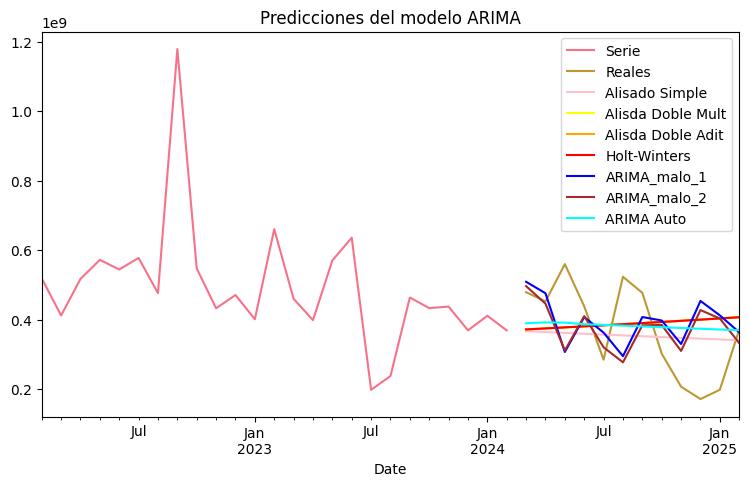

In [59]:
# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
nvd_train["Volume"].tail(25).plot(ax=ax, label='Serie')
nvd_test["Volume"].plot(ax=ax, label='Reales')

pred_final_as.plot(ax=ax, label='Alisado Simple', color="pink")
pred_final_ad_mul.plot(ax=ax, label='Alisda Doble Mult', color="Yellow")
pred_final_ad_add.plot(ax=ax, label='Alisda Doble Adit', color="orange")
pred_final_hw_am.plot(ax=ax, label='Holt-Winters', color="red")
predicciones_statsmodels1.plot(ax=ax, label='ARIMA_malo_1', color="blue")
predicciones_statsmodels2.plot(ax=ax, label='ARIMA_malo_2', color="brown")
predicciones_statsmodels_fin.plot(ax=ax, label='ARIMA Auto', color="cyan")
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

We've observed that unfortunately, no model predicts future data well. To ensure which model we have is the best, we'll look at the MSE, RMSE, and MAE errors of all the models.

In [60]:
rmse = np.sqrt(mean_squared_error(nvd_test["Volume"], predicciones_statsmodels_fin))
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print("Mean Absolute Error:", mae)
print("Root Mean Square Error:", rmse)

Mean Absolute Error: 110793817.45816338
Root Mean Square Error: 124885651.8982144


In [61]:
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 1.5596426050041982e+16
Root Mean Squared Error (RMSE): 124885651.8982144
Mean Absolute Error (MAE): 110793817.45816338


# Final Model Comparison

In [62]:

print("Modelo Alisado Simple")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], pred_final_as)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], pred_final_as)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo Alisado Doble Multiplicativo")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], pred_final_ad_mul)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], pred_final_ad_mul)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo Alisado Doble Aditivo")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], pred_final_ad_add)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], pred_final_ad_add)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo Holt-Winters")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], pred_final_hw_am)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], pred_final_hw_am)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo ARIMA Modelo 1")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels1)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels1)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo ARIMA Modelo 2")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels2)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels2)
print(f'Mean Absolute Error (MAE): {mae}')
print()

print("Modelo ARIMA Automático")
# Mean Squared Error (MSE)
mse = mean_squared_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(nvd_test["Volume"], predicciones_statsmodels_fin)
print(f'Mean Absolute Error (MAE): {mae}')

Modelo Alisado Simple
Mean Squared Error (MSE): 1.5773995965846194e+16
Root Mean Squared Error (RMSE): 125594569.81034727
Mean Absolute Error (MAE): 115068833.41386153

Modelo Alisado Doble Multiplicativo
Mean Squared Error (MSE): 1.9147344958250604e+16
Root Mean Squared Error (RMSE): 138373931.64267105
Mean Absolute Error (MAE): 124755414.88707455

Modelo Alisado Doble Aditivo
Mean Squared Error (MSE): 1.91742514199314e+16
Root Mean Squared Error (RMSE): 138471121.24891385
Mean Absolute Error (MAE): 124835359.07435916

Modelo Holt-Winters
Mean Squared Error (MSE): 1.9147344958250604e+16
Root Mean Squared Error (RMSE): 138373931.64267105
Mean Absolute Error (MAE): 124755414.88707455

Modelo ARIMA Modelo 1
Mean Squared Error (MSE): 2.3272250473274004e+16
Root Mean Squared Error (RMSE): 152552451.54789877
Mean Absolute Error (MAE): 119633340.46901308

Modelo ARIMA Modelo 2
Mean Squared Error (MSE): 2.1675678871276572e+16
Root Mean Squared Error (RMSE): 147226624.193033
Mean Absolute Erro

We see that the model created by Automatic ARIMA is the most optimal, as it has the lowest MSE, RMSE, and MAE errors. We represent this in a graph:

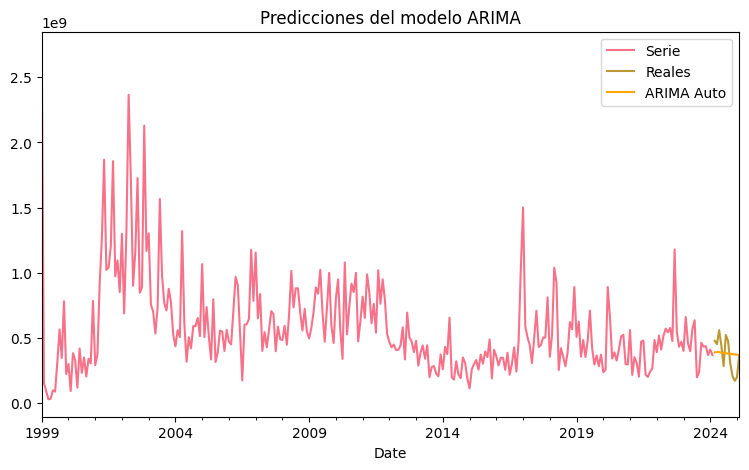

In [63]:
# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
nvd_train["Volume"].plot(ax=ax, label='Serie')
nvd_test["Volume"].plot(ax=ax, label='Reales')
predicciones_statsmodels_fin.plot(ax=ax, label='ARIMA Auto', color="orange")
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

Our final model is:

$$
\textbf{ARIMA(2,0,4)(0,0,0)[12]:} \quad
Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \theta_1 \epsilon _{t-1} + \theta_2 \epsilon _{t-2} + \theta_3 \epsilon _{t-3} + \theta_4 \epsilon _{t-4} + \epsilon_t
$$